In [103]:
from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy import integrate

from enterprise import constants as const

%matplotlib inline

In [72]:
def pow_prob(x, xmin=1, alpha=2):
    return (alpha-1)/xmin * (x/xmin)**-alpha

def logpow_prob(logx, logxmin=0, alpha=2):
    return (alpha-1)/10**logxmin * 10**(-alpha*(logx - logxmin))

def combo_prob(x, beta=1, alpha=2):
    return np.piecewise(
        x,
        [x <= 0, np.logical_and(x > 0, x <= beta), x > beta],
        [lambda x: 0,
         lambda x: (alpha-1)/(alpha*beta),
         lambda x: (alpha-1)/(alpha*beta) * (x/beta)**-alpha]
    )
# does not work for non-array x...
#    p = np.empty_like(x)
#    p[x<=0] = 0
#    p[np.logical_and(x>0, x<=beta)] = (alpha-1)/(alpha*beta)
#   mask = x>beta
#    p[mask] = (alpha-1)/(alpha*beta) * (x[mask]/beta)**-alpha
#    return p

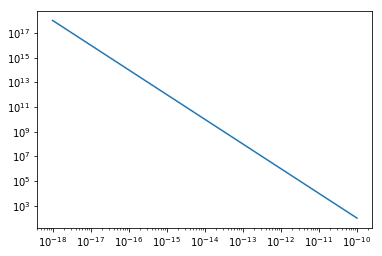

In [9]:
hs = np.logspace(-18, -10, 100)
ps = pow_prob(hs, xmin=1e-18, alpha=2)

plt.plot(hs, ps)
plt.yscale('log')
plt.xscale('log')

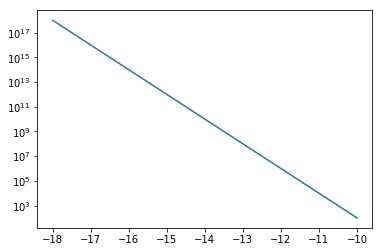

In [18]:
loghs = np.linspace(-18, -10, 100)
ps_log = logpow_prob(loghs, logxmin=-18, alpha=2)

plt.plot(loghs, ps_log)
plt.yscale('log')

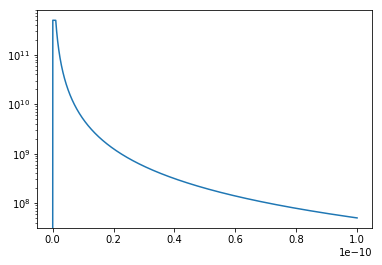

In [73]:
hs = np.linspace(0, 1e-10, int(1e5))
ps_combo = combo_prob(hs, beta=1e-12, alpha=2)

plt.plot(hs, ps_combo)
plt.yscale('log')

In [180]:
from enterprise.signals import parameter
from enterprise.signals import prior

class _vol_exp_gen(stats.rv_continuous):
    """A distribution with pdf(x) ~ 10^x for small x and ~10~-x for large x
    """
    def _rvs(self):
        """inverse transform sampling b/c cdf is analytically invertable"""
        a = np.random.uniform(size=self._size)
        return np.piecewise(
            a,
            [a <= 0.5, a > 0.5],
            [lambda a: self.loc + np.log10(2*a),
             lambda a: self.loc - np.log10(2*(1-a))]
        )

    def _pdf(self, x):
        return const.ln10/2 * np.piecewise(
            x,
            [x <= self.loc, x > self.loc],
            [lambda x: 10**(x - self.loc),
             lambda x: 10**(self.loc - x)]
        )

    def _logpdf(self, x):
        return np.log(self._pdf(x))

    def _cdf(self, x):
        return 1/2 * np.piecewise(
            x,
            [x <= self.loc, x > self.loc],
            [lambda x: 10**(x - self.loc),
             lambda x: 2 - 10**(self.loc - x)]
        )

def VolumeExpRV(loc=0):
    r""" A prior on log(x) that's uniform in x for small values and proportional to x**-2 for large
    uniform in x is proportional to 10**log(x)
    x**-2 in x is proportional to 10**-log(x)
    """
    return _vol_exp_gen(loc=loc)

def VolumeExp(loc=0, size=None):
    """Class factory for LinearExp parameters."""
    class VolumeExp(parameter.Parameter):
        _prior = prior.Prior(VolumeExpRV(loc))
        _size = size
        _loc = loc

        def __repr__(self):
            return ('"{}":VolumeExp({})'.format(self.name, loc)
                + ('' if self._size is None else '[{}]'.format(self._size)))

    return VolumeExp

In [181]:
logh = VolumeExp(-13)

TypeError: __init__() got an unexpected keyword argument 'loc'

In [129]:
def pdf(logx, logb=0):
    return const.ln10/2 * np.piecewise(
            logx,
            [logx <= logb, logx > logb],
            [lambda logx: 10**(logx - logb),
             lambda logx: 10**(logb - logx)
            ]
        )

def cdf(logx, logb=0):
        return 1/2 * np.piecewise(
            logx,
            [logx <= logb, logx > logb],
            [lambda logx: 10**(logx-logb),
             lambda logx: 2 - 10**(logb-logx)
            ]
        )

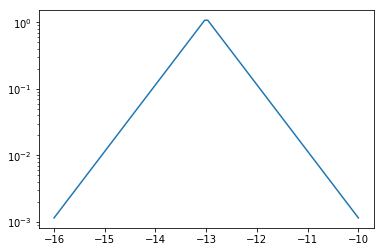

In [182]:
loghs = np.linspace(-16, -10, 100)
p = pdf(loghs, logb=-13)
c = cdf(loghs, logb=-13)

plt.plot(loghs, p)
#plt.plot(loghs, c)
plt.yscale('log')

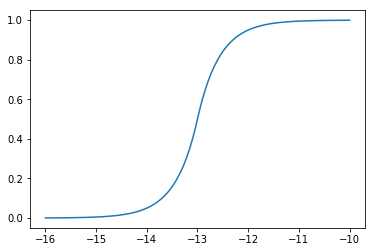

In [131]:
plt.plot(loghs, c)

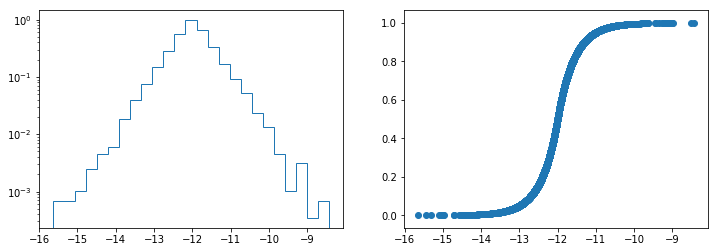

In [167]:
b = -12
N = int(1e4)
c = np.random.uniform(0, 1, size=N)
samples = np.piecewise(
    c,
    [c <= 0.5, c > 0.5],
    [lambda c: b + np.log10(2*c),
     lambda c: b - np.log10(2*(1-c))]
)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(samples, bins=25, density=True, histtype='step');
plt.yscale('log')
plt.subplot(122)
plt.scatter(samples, c)
